**recsys-cluster-loss**

Example of cluster analysis in the context of recommendation systems.
Users who receive recommendations will be grouped based on the individual fairness measure of those recommendations.
The objective is to analyze whether there is any type of injustice of non-obvious user groups, that is, groups that cannot be configured based on some explicit user characteristic (variable) (for example: gender, age, etc.) .

Two methods of grouping will be applied:
1. Hierarchical clustering (tree clustering - dendrogram)
2. Non-hierarchical grouping by breakdown (grouping by k-Means)

In this file we are analyzing the possible groupings considering the following variable(s):
- loss: individual injustice

Recommendation system: generating the recommendation matrix and calculating individual fairness

In [1]:
# cloning repository with database
!rm -rf recsys-cluster-loss
!git clone https://github.com/ravarmes/recsys-cluster-loss.git

Cloning into 'recsys-cluster-loss'...


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [3]:
import sys
sys.path.append('recsys-cluster-loss/src')
from RecSys import RecSys
from UserFairness import IndividualLossVariance

In [4]:
# reading data from 3883 movies and 6040 users 
Data_path = 'recsys-cluster-loss/data/Books'
n_users=  300
n_items= 1000
top_users = True # True: to use users with more ratings; False: otherwise
top_items = False # True: to use movies with more ratings; False: otherwise

In [5]:
# recommendation algorithm
algorithm = 'RecSysALS'

In [6]:
# parameters for calculating fairness measures
l = 5
theta = 3
k = 3

In [7]:
recsys = RecSys(n_users, n_items, top_users, top_items, l, theta, k)

In [8]:
X, users_info, items_info = recsys.read_books(n_users, n_items, top_users, top_items, data_dir = Data_path) # returns matrix of ratings with n_users rows and n_moveis columns
omega = ~X.isnull() # matrix X with True in cells with evaluations and False in cells not rated

In [9]:
users_info

,Location,Age
1,"nyc, new york, usa",18
2,"stockton, california, usa",58
3,"moscow, yukon territory, russia",51
4,"porto, v.n.gaia, portugal",73
5,"farnborough, hants, united kingdom",52
...,...,...
29996,"park forest, illinois, usa",65
29997,"calgary, alberta, canada",38
29998,"loxley, alabama, usa",59
29999,"salina, kansas, usa",50


In [10]:
X_est = recsys.compute_X_est(X, algorithm, Data_path) # RecSysALS or RecSysKNN or RecSysNMF or RecSysExampleAntidoteData20Items

In [11]:
ilv = IndividualLossVariance(X, omega, 1)
losses = ilv.get_losses(X_est)

In [12]:
losses

UserID
11676    1.406421
16795    1.193364
2110     0.908189
2030     0.186139
1733     0.424401
           ...   
2559     0.436580
2644     0.448597
2651     0.448835
2653     0.500000
2678     0.500000
Length: 300, dtype: float64

In [13]:
df = pd.DataFrame(columns=['Location', 'Age', 'Loss'])
df['Location'] = users_info['Location']
df['Age'] = users_info['Age']
df['Loss'] = losses

df.dropna(subset=['Loss'], inplace=True) # eliminating rows with empty values in the 'Loss' column
df

,Location,Age,Loss
254,"minneapolis, minnesota, usa",34,0.370001
638,"san diego, california, usa",51,0.600132
882,"berkeley, california, usa",52,2.201142
929,"king of prussia, ,",35,0.482739
1131,"berkeley, ,",28,0.950329
...,...,...,...
28634,"bad axe, michigan, usa",69,0.432956
28647,"aspinwall, pennsylvania, usa",18,0.793706
29209,"boca raton, florida, usa",48,2.007592
29259,"mt. airy, , usa",66,0.556470


In [14]:
df.head()

,Location,Age,Loss
254,"minneapolis, minnesota, usa",34,0.370001
638,"san diego, california, usa",51,0.600132
882,"berkeley, california, usa",52,2.201142
929,"king of prussia, ,",35,0.482739
1131,"berkeley, ,",28,0.950329


In [15]:
# number of rows and columns:
df.shape

(300, 3)

In [16]:
# descriptive statistics:
df.describe()

,Age,Loss
count,300.000000,300.000000
mean,43.686667,1.029915
std,17.518509,1.138689
min,14.000000,0.042335
25%,28.750000,0.438007
50%,43.000000,0.666281
75%,59.000000,1.289607
max,75.000000,11.359402


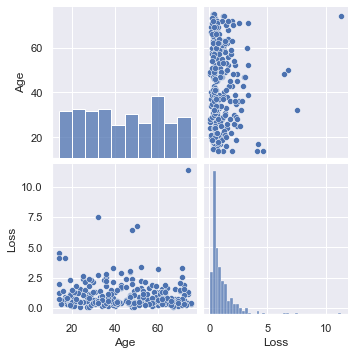

In [17]:
sns.pairplot(df)

<AxesSubplot:>

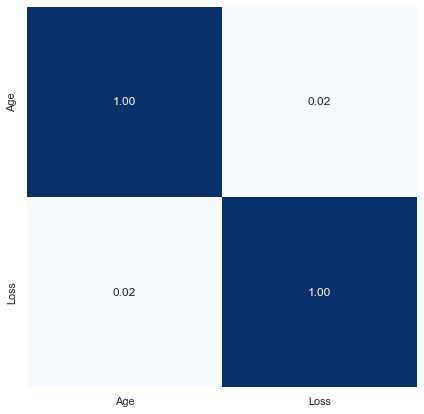

In [18]:
df2 = df.drop(['Location'] , axis=1) # eliminating Location (non-numeric) columns to analyze correlations

plt.figure(figsize=(7, 7))
corr = np.corrcoef(df2.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=df2.columns, yticklabels=df2.columns)

Hierarchical clustering (tree clustering - dendrogram)

In [19]:
# Leaving only the loss column to perform cluster analysis
#df2 = df2.drop('Loss', 1)
df2 = df2.drop('Location', 1) 
df2 = df2.drop('Age', 1) 

KeyError: "['Location'] not found in axis"

In [ ]:
df_scaled = df2.copy()
df_scaled.iloc[:, :] = StandardScaler().fit_transform(df2)

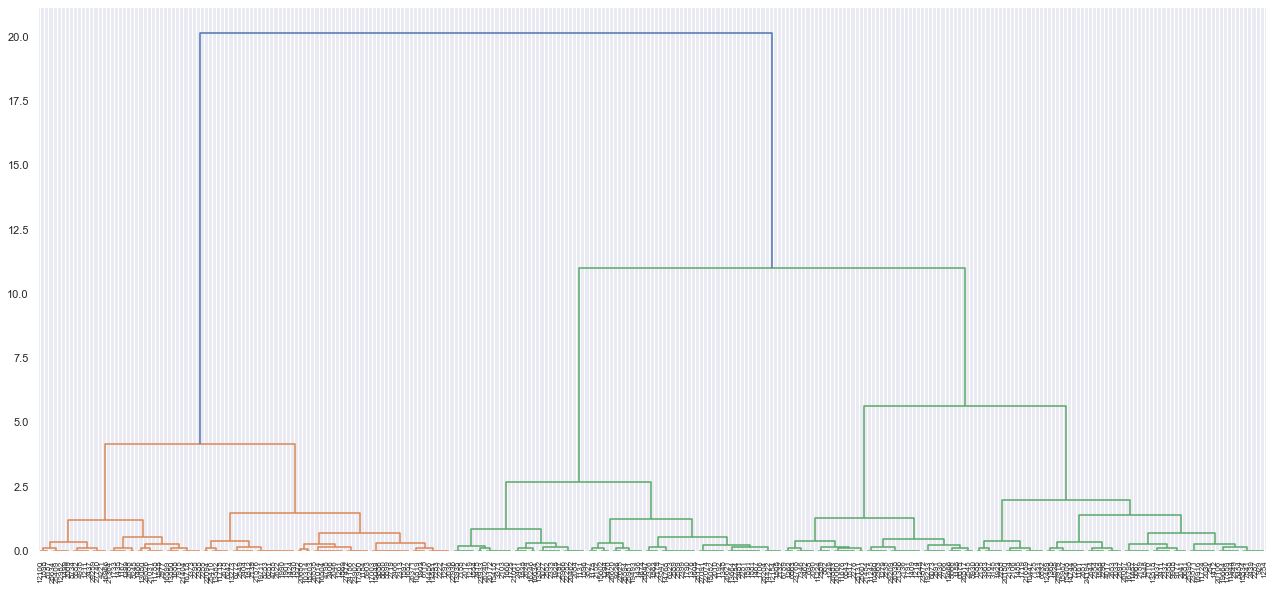

In [ ]:
Z = hierarchy.linkage(df_scaled, 'ward') #complete or ward
plt.figure(figsize=(22, 10))
plt.grid(axis='y')
dn = hierarchy.dendrogram(Z, labels=list(df.index), leaf_font_size=8)

In [ ]:
n_clusters = 3
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
groups = cluster.fit_predict(df2)

In [ ]:
groups

array([0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 0, 2, 0, 0, 0, 1, 0, 0, 2, 1,
       0, 2, 0, 1, 2, 1, 0, 0, 1, 1, 2, 1, 2, 0, 1, 0, 0, 1, 2, 0, 0, 0,
       1, 2, 1, 2, 2, 1, 2, 0, 2, 1, 2, 0, 2, 1, 1, 0, 0, 2, 1, 2, 2, 1,
       1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       0, 1, 2, 2, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0,
       0, 1, 0, 2, 1, 1, 0, 2, 1, 0, 0, 0, 1, 2, 2, 0, 1, 0, 2, 2, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 2, 1, 2, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 2, 0, 2, 1, 1, 1, 0, 1, 0, 1, 2, 0, 1, 2, 2, 1, 0,
       2, 1, 0, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 2, 1, 0, 2,
       0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 0, 2, 2,
       2, 0, 0, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1, 0, 0, 2, 0, 2, 1, 0, 1, 0,
       2, 2, 0, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 1], d

In [ ]:

users = list(df2.index)
grouped_users = {i: [] for i in range(n_clusters)}
for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}\n')

Cluster 0: [254, 638, 882, 929, 1131, 1155, 1161, 1214, 1248, 1249, 1254, 1262, 1279, 1331, 1368, 1409, 1412, 1485, 1517, 1535, 1558, 1585, 1596, 1719, 1791, 1838, 1848, 1923, 1928, 2024, 2030, 2033, 2041, 2084, 2090, 2106, 2110, 2134, 2135, 2136, 2189, 2197, 2238, 2276, 2287, 2288, 2296, 2333, 2337, 2349, 2354, 2358, 2363, 2389, 2411, 2439, 2461, 2462, 2545, 2552, 2597, 2630, 2644, 2651, 2653, 2766, 2891, 3145, 3167, 3363, 4017, 5027, 5037, 6073, 6532, 6543, 6563, 6575, 6789, 7125, 7286, 7346, 7841, 8066, 8067, 8454, 8681, 8930, 9177, 9908, 10447, 10560, 11224, 11245, 11657, 11676, 11724, 11944, 12489, 13518, 13552, 13666, 14744, 15408, 15834, 15957, 16246, 16634, 16795, 16916, 17859, 19233, 19664, 20060, 20106, 20180, 20462, 21011, 21356, 21484, 21659, 22252, 23571, 23768, 23872, 24194, 25395, 25919, 25966, 26057, 26517, 26538, 26883, 29209]

Cluster 1: [1167, 1184, 1211, 1261, 1297, 1372, 1399, 1424, 1435, 1466, 1499, 1548, 1597, 1652, 1688, 1733, 1812, 1830, 1869, 1898, 1901, 1903,

Non-hierarchical grouping (K-means)

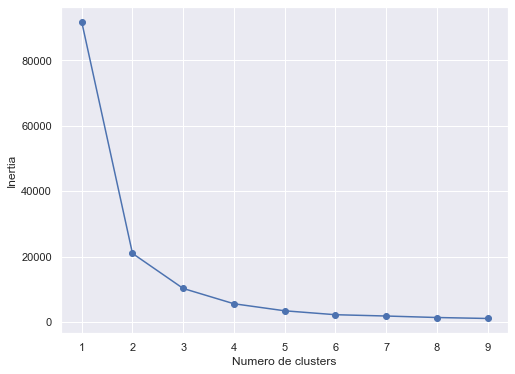

In [ ]:
inertias = []
for k in np.arange(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df2)
    inertias.append(kmeans.inertia_)

# plotting the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 10), inertias, '-o')
plt.xlabel('Numero de clusters')
plt.ylabel('Inertia');

In [ ]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
df_scaled['cluster'] = kmeans.fit_predict(df_scaled)

In [ ]:
df_scaled

,Age,cluster
254,-0.553863,0
638,0.418161,0
882,0.475339,0
929,-0.496685,0
1131,-0.896930,2
...,...,...
28634,1.447362,1
28647,-1.468709,2
29209,0.246627,0
29259,1.275829,1


In [ ]:
users = list(df_scaled.index)
groups = df_scaled['cluster']

grouped_users = {i: [] for i in range(n_clusters)}

for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}\n')

Cluster 0: [254, 638, 882, 929, 1155, 1214, 1248, 1249, 1254, 1262, 1279, 1331, 1409, 1412, 1485, 1517, 1585, 1719, 1791, 1848, 1923, 2030, 2041, 2090, 2106, 2110, 2134, 2135, 2136, 2189, 2238, 2276, 2287, 2288, 2337, 2349, 2358, 2363, 2389, 2411, 2439, 2462, 2545, 2630, 2766, 2891, 3145, 3167, 3363, 5037, 6073, 6532, 6543, 6563, 6575, 6789, 7125, 7346, 7841, 8066, 8067, 8454, 8681, 8930, 9177, 9908, 10447, 10560, 11224, 11245, 11657, 11676, 11724, 11944, 13518, 13666, 15834, 16795, 16916, 17859, 19233, 19664, 20060, 20106, 20180, 21356, 21484, 21659, 23571, 23768, 23872, 25395, 26057, 26517, 26538, 26883, 29209]

Cluster 1: [1167, 1184, 1211, 1261, 1297, 1372, 1399, 1424, 1435, 1466, 1499, 1548, 1597, 1652, 1688, 1733, 1812, 1830, 1869, 1898, 1901, 1903, 1990, 2009, 2036, 2046, 2139, 2222, 2255, 2295, 2313, 2385, 2404, 2406, 2437, 2466, 2549, 2622, 2678, 2688, 2719, 2977, 3373, 4221, 4785, 4795, 4938, 5582, 5899, 5903, 6115, 6242, 6251, 6772, 7283, 7915, 8187, 8245, 8253, 8680, 8734, 